In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [70]:
df0 = pd.read_csv('sp500sub.csv', index_col='Date', parse_dates=True)

In [71]:
df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [72]:
df['LogClose'] = np.log(df['Close'])

In [73]:
df['DiffLogClose'] = df['LogClose'].diff()

In [74]:
df.head()

,Close,LogClose,DiffLogClose
Date,,,
2010-01-04,11.525,2.444519,NaN
2010-01-05,11.795,2.467676,0.023157
2010-01-06,11.710,2.460443,-0.007233
2010-01-07,11.680,2.457878,-0.002565
2010-01-08,11.640,2.454447,-0.003431


In [75]:
Ntest = 21
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [76]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogClose']])
test_scaled = scaler.fit_transform(test[['DiffLogClose']])

In [77]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [78]:
df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

In [79]:
# make supervised dataset

series = df['ScaledLogReturn'].dropna().to_numpy()

T = 10 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [80]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [81]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [82]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [83]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=200,
    validation_data=(Xtest, Ytest)
)

Epoch 1/200
70/70 [==============================] - 0s 2ms/step - loss: 1.2010 - val_loss: 0.8988
Epoch 2/200
70/70 [==============================] - 0s 790us/step - loss: 1.0898 - val_loss: 0.9212
Epoch 3/200
70/70 [==============================] - 0s 704us/step - loss: 1.0512 - val_loss: 0.9348
Epoch 4/200
70/70 [==============================] - 0s 902us/step - loss: 1.0312 - val_loss: 0.9492
Epoch 5/200
70/70 [==============================] - 0s 708us/step - loss: 1.0201 - val_loss: 0.9490
Epoch 6/200
70/70 [==============================] - 0s 665us/step - loss: 1.0094 - val_loss: 0.9468
Epoch 7/200
70/70 [==============================] - 0s 673us/step - loss: 1.0014 - val_loss: 0.9508
Epoch 8/200
70/70 [==============================] - 0s 715us/step - loss: 0.9940 - val_loss: 0.9478
Epoch 9/200
70/70 [==============================] - 0s 791us/step - loss: 0.9885 - val_loss: 0.9558
Epoch 10/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9845 - val_loss: 

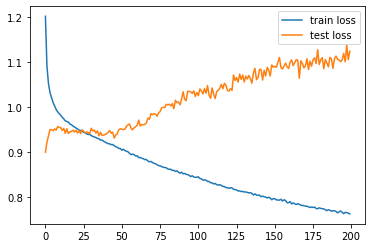

In [84]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [85]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [86]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

In [87]:
Ptrain = scaler.inverse_transform(Ptrain).flatten()
Ptest = scaler.inverse_transform(Ptest).flatten()

In [88]:
df.head()

,Close,LogClose,DiffLogClose,ScaledLogReturn
Date,,,,
2010-01-04,11.525,2.444519,NaN,NaN
2010-01-05,11.795,2.467676,0.023157,1.474542
2010-01-06,11.710,2.460443,-0.007233,-0.527921
2010-01-07,11.680,2.457878,-0.002565,-0.220375
2010-01-08,11.640,2.454447,-0.003431,-0.277396


In [89]:
# Store diff predictions
df.loc[train_idx, 'Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Diff ANN Test Prediction'] = Ptest

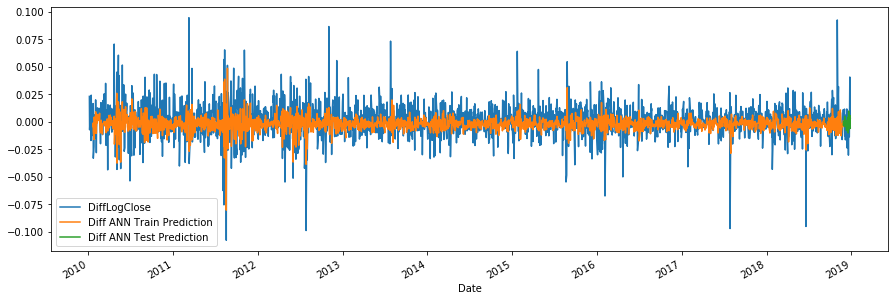

In [90]:
cols = ['DiffLogClose',
        'Diff ANN Train Prediction',
        'Diff ANN Test Prediction']
df[cols].plot(figsize=(15,5));

In [91]:
# Needed to compute un-diff predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [92]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [93]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

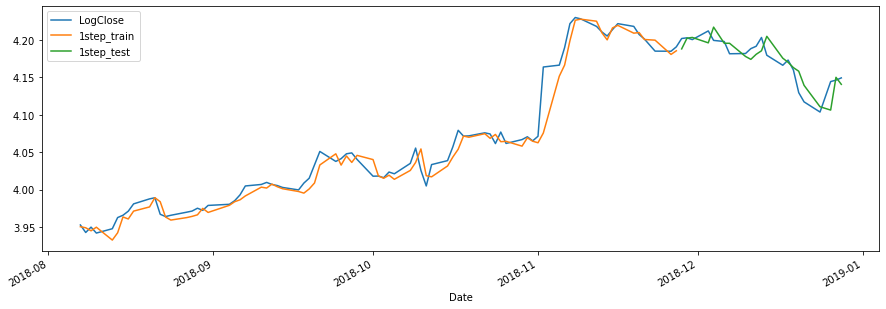

In [94]:
# plot 1-step forecast
df.iloc[-100:][['LogClose','1step_train','1step_test']].plot(figsize=(15,5));

In [95]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1,-1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [96]:
# unscale
multistep_predictions = np.array(multistep_predictions)
multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1,1)).flatten()

In [97]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

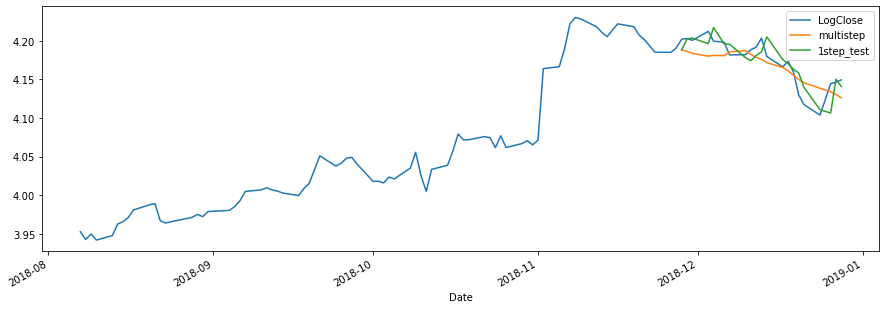

In [98]:
# plot 1-step and multistep forecast
df.iloc[-100:][['LogClose','multistep','1step_test']].plot(figsize=(15,5));

In [99]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


In [100]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [101]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i,x)

In [102]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [103]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=100,
    validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 1.1621 - val_loss: 1.0592
Epoch 2/100
70/70 [==============================] - 0s 756us/step - loss: 1.0687 - val_loss: 1.0273
Epoch 3/100
70/70 [==============================] - 0s 813us/step - loss: 1.0385 - val_loss: 1.0103
Epoch 4/100
70/70 [==============================] - 0s 934us/step - loss: 1.0232 - val_loss: 1.0089
Epoch 5/100
70/70 [==============================] - 0s 751us/step - loss: 1.0141 - val_loss: 1.0016
Epoch 6/100
70/70 [==============================] - 0s 850us/step - loss: 1.0081 - val_loss: 0.9999
Epoch 7/100
70/70 [==============================] - 0s 970us/step - loss: 1.0037 - val_loss: 1.0109
Epoch 8/100
70/70 [==============================] - 0s 1ms/step - loss: 1.0005 - val_loss: 1.0066
Epoch 9/100
70/70 [==============================] - 0s 833us/step - loss: 0.9981 - val_loss: 1.0076
Epoch 10/100
70/70 [==============================] - 0s 914us/step - loss: 0.9962 - val_loss: 

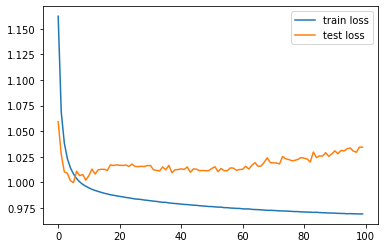

In [104]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [118]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

In [119]:
Ptrain.shape, Ptest.shape

((2231, 1), (21, 1))

In [120]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [121]:
# unscale
Ptest = scaler.inverse_transform(Ptest.reshape(-1,1)).flatten()

In [122]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

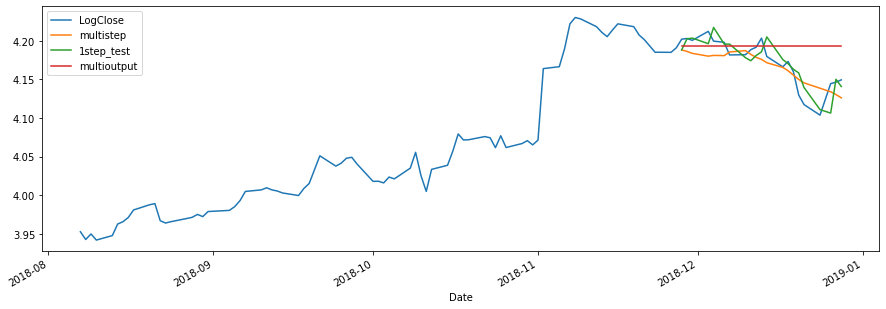

In [123]:
# plot all forecasts
cols = ['LogClose','multistep','1step_test','multioutput']
df.iloc[-100:][cols].plot(figsize=(15,5));

In [124]:
# MAPE
test_log_loss = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.003767136771133129
multi-output MAPE: 0.0063548973317073265


1-step Binary Classification

In [125]:
Ytrain_b = (Ytrain > 0) * 1
Ytest_b = (Ytest > 0) * 1

In [126]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [127]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'],
)

In [128]:
r = model.fit(
    Xtrain,
    Ytrain_b,
    epochs=100,
    validation_data=(Xtest, Ytest_b)
)

Epoch 1/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7153 - accuracy: 0.5186 - val_loss: 0.7069 - val_accuracy: 0.4762
Epoch 2/100
70/70 [==============================] - 0s 787us/step - loss: 0.7009 - accuracy: 0.5078 - val_loss: 0.7087 - val_accuracy: 0.4286
Epoch 3/100
70/70 [==============================] - 0s 829us/step - loss: 0.6960 - accuracy: 0.5052 - val_loss: 0.7014 - val_accuracy: 0.4286
Epoch 4/100
70/70 [==============================] - 0s 987us/step - loss: 0.6926 - accuracy: 0.5069 - val_loss: 0.7035 - val_accuracy: 0.4286
Epoch 5/100
70/70 [==============================] - 0s 828us/step - loss: 0.6903 - accuracy: 0.5096 - val_loss: 0.6998 - val_accuracy: 0.4286
Epoch 6/100
70/70 [==============================] - 0s 833us/step - loss: 0.6884 - accuracy: 0.5119 - val_loss: 0.6993 - val_accuracy: 0.4286
Epoch 7/100
70/70 [==============================] - 0s 811us/step - loss: 0.6867 - accuracy: 0.5105 - val_loss: 0.6950 - val_accuracy: 0.4286
E

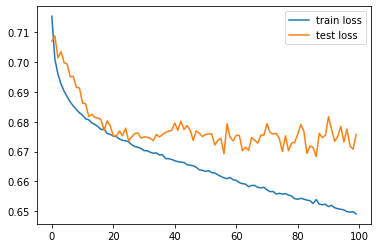

In [129]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

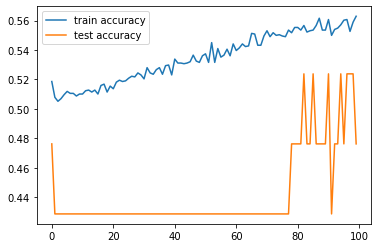

In [130]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend();